<a href="https://colab.research.google.com/github/NotYeshwanthReddy/Air_Pollution_Prediction/blob/main/Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup only for Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Projects/Pakkanodi Assignments/Air pollution")

# Load and Format Data

In [ ]:
import pandas as pd

df = pd.read_csv("air-quality-india.csv")
print("Column Names: ",df.columns)
print("Shape: ", df.shape)

df['Date'] = df['Timestamp'].apply(lambda x : x.split(' ')[0])

df = pd.DataFrame(df.groupby('Date')['PM2.5'].mean())
# df.drop(['Year', 'Month', 'Day', 'Hour'], axis=1, inplace=True)
# df = df.set_index("Timestamp")

print("Column Names: ",df.columns)
print("Shape: ", df.shape)
df.head()

Column Names:  Index(['Timestamp', 'Year', 'Month', 'Day', 'Hour', 'PM2.5'], dtype='object')
Shape:  (36192, 6)
Column Names:  Index(['PM2.5'], dtype='object')
Shape:  (1616, 1)


,PM2.5
Date,
2017-11-07,99.805833
2017-11-08,110.979565
2017-11-09,114.915833
2017-11-10,119.404091
2017-11-11,109.267273


# Visualize time series

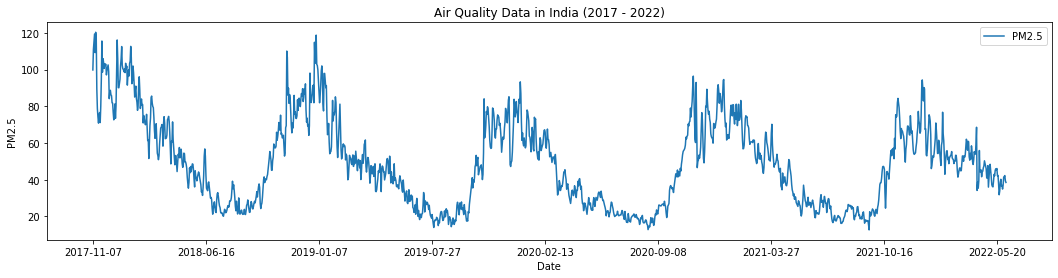

In [ ]:
import matplotlib.pyplot as plt

df['PM2.5'].plot(kind = 'line',
                 xlabel = "Date",
                 ylabel = "PM2.5",
                 figsize = (18,4),
                #  rot = 90,
                 legend = True)
plt.title("Air Quality Data in India (2017 - 2022)")
plt.show()

In [ ]:
print((df.index[0], df.index[-1]))

('2017-11-07', '2022-06-04')


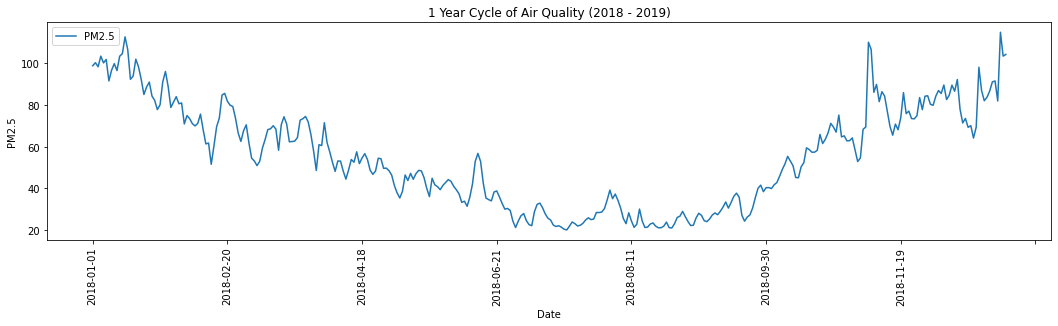

In [ ]:
df.loc['2018-01-01':'2019-01-01'].plot(kind = 'line',
                 xlabel = "Date",
                 ylabel = "PM2.5",
                 figsize = (18,4),
                 rot = 90,
                 legend = True)
plt.title("1 Year Cycle of Air Quality (2018 - 2019)")
plt.show()

# Simple LSTM with 1 layer

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
dataset = df.values
dataset = dataset.astype('float32')

## Normalize

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## Train Test Split

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1082 534


## Model Config

In [ ]:
look_back = 100

epochs = 30
batch_size = 1
verbose = 2

## create training data

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## lstm model creation

In [ ]:
# create and fit the LSTM network
lstm_model = Sequential()
lstm_model.add(LSTM(1, input_shape=(1, look_back)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
hist = lstm_model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/30
981/981 - 5s - loss: 0.0184 - 5s/epoch - 5ms/step
Epoch 2/30
981/981 - 3s - loss: 0.0064 - 3s/epoch - 3ms/step
Epoch 3/30
981/981 - 2s - loss: 0.0056 - 2s/epoch - 2ms/step
Epoch 4/30
981/981 - 1s - loss: 0.0052 - 1s/epoch - 1ms/step
Epoch 5/30
981/981 - 1s - loss: 0.0047 - 1s/epoch - 1ms/step
Epoch 6/30
981/981 - 1s - loss: 0.0045 - 1s/epoch - 1ms/step
Epoch 7/30
981/981 - 1s - loss: 0.0042 - 1s/epoch - 1ms/step
Epoch 8/30
981/981 - 1s - loss: 0.0039 - 1s/epoch - 1ms/step
Epoch 9/30
981/981 - 1s - loss: 0.0038 - 1s/epoch - 1ms/step
Epoch 10/30
981/981 - 1s - loss: 0.0037 - 1s/epoch - 1ms/step
Epoch 11/30
981/981 - 1s - loss: 0.0037 - 1s/epoch - 1ms/step
Epoch 12/30
981/981 - 1s - loss: 0.0035 - 1s/epoch - 1ms/step
Epoch 13/30
981/981 - 1s - loss: 0.0033 - 1s/epoch - 1ms/step
Epoch 14/30
981/981 - 1s - loss: 0.0033 - 1s/epoch - 1ms/step
Epoch 15/30
981/981 - 1s - loss: 0.0033 - 1s/epoch - 1ms/step
Epoch 16/30
981/981 - 1s - loss: 0.0034 - 1s/epoch - 1ms/step
Epoch 17/30
981/9

## lstm prediction

In [ ]:
# make predictions
trainPredict = lstm_model.predict(trainX)
testPredict = lstm_model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
inverse_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
inverse_testY = scaler.inverse_transform([testY])

### plot lstm prediction

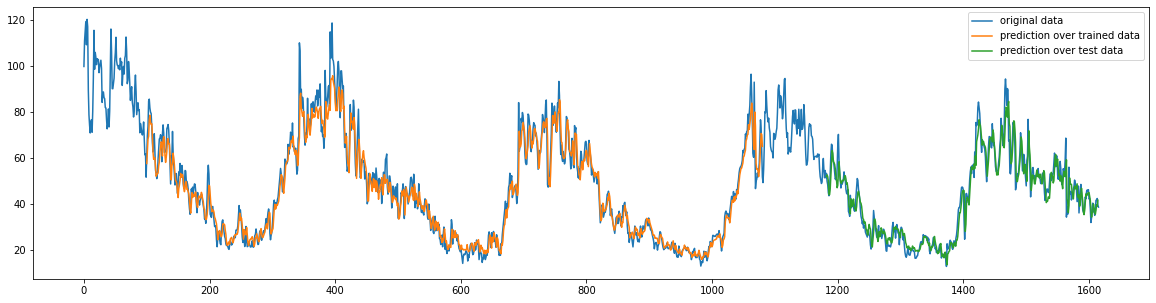

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt_1 = plt.figure(figsize=(20, 5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(["original data","prediction over trained data", "prediction over test data"], loc="upper right")
plt.show()

## auto-regressive lstm prediction

In [ ]:
from tqdm import tqdm


auto_reg_test = np.array([testX[0]])
auto_reg_pred = []
for i in tqdm(range(len(test)-look_back-1)):
  pred = lstm_model.predict(auto_reg_test)[0]
  auto_reg_pred.append(pred)
  auto_reg_test = list(auto_reg_test[0][0])[1:]
  auto_reg_test.append(pred[0])
  auto_reg_test = np.array([[auto_reg_test]])


auto_reg_pred = np.array(auto_reg_pred)
auto_reg_pred = scaler.inverse_transform(auto_reg_pred)

100%|██████████| 433/433 [00:21<00:00, 20.04it/s]


### plot autoregressive lstm prediction

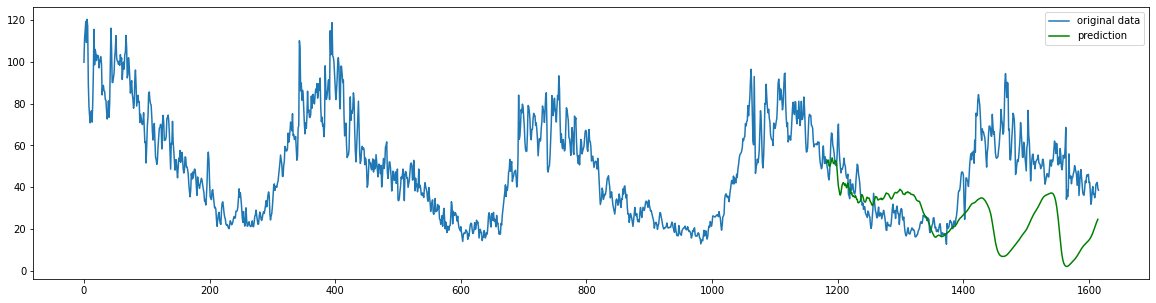

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = auto_reg_pred
# plot baseline and predictions
plt_1 = plt.figure(figsize=(20, 5))
plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
plt.plot(testPredictPlot, color='g')
plt.legend(["original data", "prediction"], loc="upper right")
plt.show()

## lstm evaluation scores

In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(inverse_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(inverse_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.35 RMSE
Test Score: 5.07 RMSE


In [ ]:
from sklearn.metrics import r2_score

trainScore = r2_score(inverse_trainY[0], trainPredict[:,0])
print('Train Score: %.5f R2' % (trainScore))
testScore = r2_score(inverse_testY[0], testPredict[:,0])
print('Test Score: %.5f R2' % (testScore))

Train Score: 0.93886 R2
Test Score: 0.91457 R2


# Bi-directional LSTM with 1 layer

## imports

In [ ]:
from tensorflow.keras.layers import Bidirectional

## bi-lstm model creation

In [ ]:
# create and fit the Bi-directional LSTM network
bilstm_model = Sequential()
# adding bi-directional layer
bilstm_model.add(Bidirectional(LSTM(1, input_shape=(1, look_back))))
bilstm_model.add(Dense(1))
bilstm_model.compile(loss='mean_squared_error', optimizer='adam')
hist = bilstm_model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/30
981/981 - 5s - loss: 0.0095 - 5s/epoch - 6ms/step
Epoch 2/30
981/981 - 2s - loss: 0.0058 - 2s/epoch - 2ms/step
Epoch 3/30
981/981 - 2s - loss: 0.0049 - 2s/epoch - 2ms/step
Epoch 4/30
981/981 - 2s - loss: 0.0046 - 2s/epoch - 2ms/step
Epoch 5/30
981/981 - 2s - loss: 0.0044 - 2s/epoch - 2ms/step
Epoch 6/30
981/981 - 2s - loss: 0.0043 - 2s/epoch - 2ms/step
Epoch 7/30
981/981 - 2s - loss: 0.0038 - 2s/epoch - 2ms/step
Epoch 8/30
981/981 - 2s - loss: 0.0036 - 2s/epoch - 2ms/step
Epoch 9/30
981/981 - 2s - loss: 0.0036 - 2s/epoch - 2ms/step
Epoch 10/30
981/981 - 2s - loss: 0.0034 - 2s/epoch - 2ms/step
Epoch 11/30
981/981 - 2s - loss: 0.0034 - 2s/epoch - 2ms/step
Epoch 12/30
981/981 - 2s - loss: 0.0031 - 2s/epoch - 2ms/step
Epoch 13/30
981/981 - 2s - loss: 0.0032 - 2s/epoch - 2ms/step
Epoch 14/30
981/981 - 2s - loss: 0.0031 - 2s/epoch - 2ms/step
Epoch 15/30
981/981 - 2s - loss: 0.0032 - 2s/epoch - 2ms/step
Epoch 16/30
981/981 - 2s - loss: 0.0029 - 2s/epoch - 2ms/step
Epoch 17/30
981/9

## get predictions

In [ ]:
# make predictions
trainPredict = bilstm_model.predict(trainX)
testPredict = bilstm_model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
inverse_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
inverse_testY = scaler.inverse_transform([testY])

### plot bi-lstm prediction

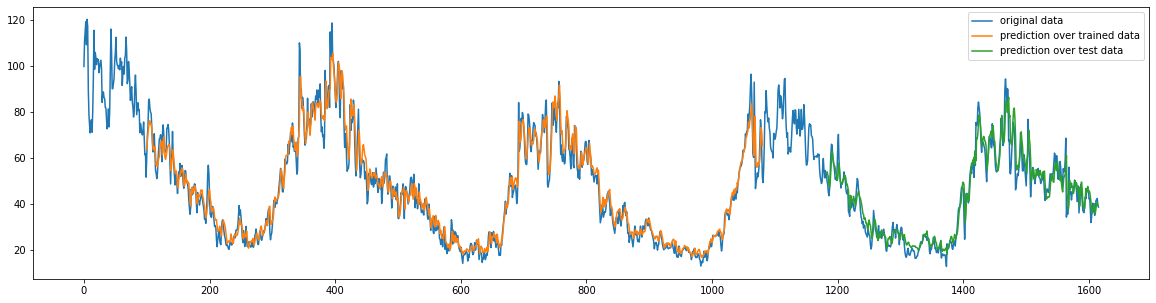

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt_1 = plt.figure(figsize=(20, 5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(["original data","prediction over trained data", "prediction over test data"], loc="upper right")
plt.show()

## autoregressive bi-lstm prediction

In [ ]:
from tqdm import tqdm


auto_reg_test = np.array([testX[0]])
auto_reg_pred = []
for i in tqdm(range(len(test)-look_back-1)):
  pred = bilstm_model.predict(auto_reg_test)[0]
  auto_reg_pred.append(pred)
  auto_reg_test = list(auto_reg_test[0][0])[1:]
  auto_reg_test.append(pred[0])
  auto_reg_test = np.array([[auto_reg_test]])


auto_reg_pred = np.array(auto_reg_pred)
auto_reg_pred = scaler.inverse_transform(auto_reg_pred)

100%|██████████| 433/433 [00:21<00:00, 20.29it/s]


### plot autoregressive bi-lstm prediction

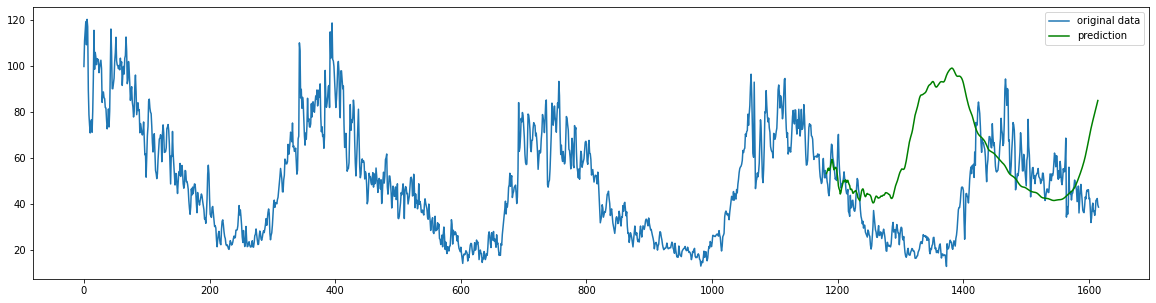

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = auto_reg_pred
# plot baseline and predictions
plt_1 = plt.figure(figsize=(20, 5))
plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
plt.plot(testPredictPlot, color='g')
plt.legend(["original data", "prediction"], loc="upper right")
plt.show()

## bi-lstm evaluation scores

In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(inverse_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(inverse_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.02 RMSE
Test Score: 5.25 RMSE


In [ ]:
trainScore = r2_score(inverse_trainY[0], trainPredict[:,0])
print('Train Score: %.5f R2' % (trainScore))
testScore = r2_score(inverse_testY[0], testPredict[:,0])
print('Test Score: %.5f R2' % (testScore))

Train Score: 0.94630 R2
Test Score: 0.90838 R2


# Simple GRU with 1 layer

## imports

In [ ]:
from tensorflow.keras.layers import GRU

## gru model creation

In [ ]:
# create and fit the Bi-directional LSTM network
gru_model = Sequential()
# adding bi-directional layer
gru_model.add(GRU(1, input_shape=(1, look_back)))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')
hist = gru_model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/30
981/981 - 3s - loss: 0.0091 - 3s/epoch - 3ms/step
Epoch 2/30
981/981 - 1s - loss: 0.0068 - 1s/epoch - 2ms/step
Epoch 3/30
981/981 - 1s - loss: 0.0057 - 1s/epoch - 2ms/step
Epoch 4/30
981/981 - 2s - loss: 0.0051 - 2s/epoch - 2ms/step
Epoch 5/30
981/981 - 1s - loss: 0.0046 - 1s/epoch - 1ms/step
Epoch 6/30
981/981 - 2s - loss: 0.0042 - 2s/epoch - 2ms/step
Epoch 7/30
981/981 - 1s - loss: 0.0039 - 1s/epoch - 2ms/step
Epoch 8/30
981/981 - 1s - loss: 0.0037 - 1s/epoch - 2ms/step
Epoch 9/30
981/981 - 1s - loss: 0.0036 - 1s/epoch - 1ms/step
Epoch 10/30
981/981 - 2s - loss: 0.0035 - 2s/epoch - 2ms/step
Epoch 11/30
981/981 - 1s - loss: 0.0033 - 1s/epoch - 2ms/step
Epoch 12/30
981/981 - 1s - loss: 0.0033 - 1s/epoch - 2ms/step
Epoch 13/30
981/981 - 1s - loss: 0.0031 - 1s/epoch - 2ms/step
Epoch 14/30
981/981 - 1s - loss: 0.0031 - 1s/epoch - 1ms/step
Epoch 15/30
981/981 - 2s - loss: 0.0031 - 2s/epoch - 2ms/step
Epoch 16/30
981/981 - 1s - loss: 0.0032 - 1s/epoch - 2ms/step
Epoch 17/30
981/9

## get predictions

In [ ]:
# make predictions
trainPredict = gru_model.predict(trainX)
testPredict = gru_model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
inverse_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
inverse_testY = scaler.inverse_transform([testY])

### plot gru prediction

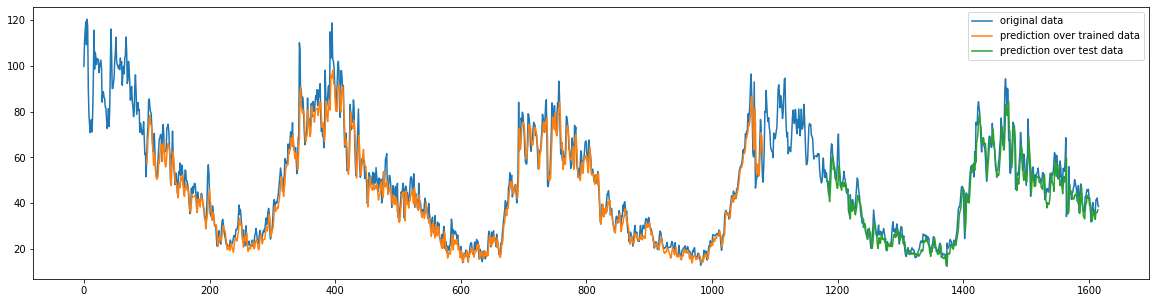

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt_1 = plt.figure(figsize=(20, 5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(["original data","prediction over trained data", "prediction over test data"], loc="upper right")
plt.show()

## auto-regressive gru prediction

In [ ]:
from tqdm import tqdm


auto_reg_test = np.array([testX[0]])
auto_reg_pred = []
for i in tqdm(range(len(test)-look_back-1)):
  pred = gru_model.predict(auto_reg_test)[0]
  auto_reg_pred.append(pred)
  auto_reg_test = list(auto_reg_test[0][0])[1:]
  auto_reg_test.append(pred[0])
  auto_reg_test = np.array([[auto_reg_test]])


auto_reg_pred = np.array(auto_reg_pred)
auto_reg_pred = scaler.inverse_transform(auto_reg_pred)

100%|██████████| 433/433 [00:20<00:00, 20.71it/s]


### plot auto-regressive gru prediction

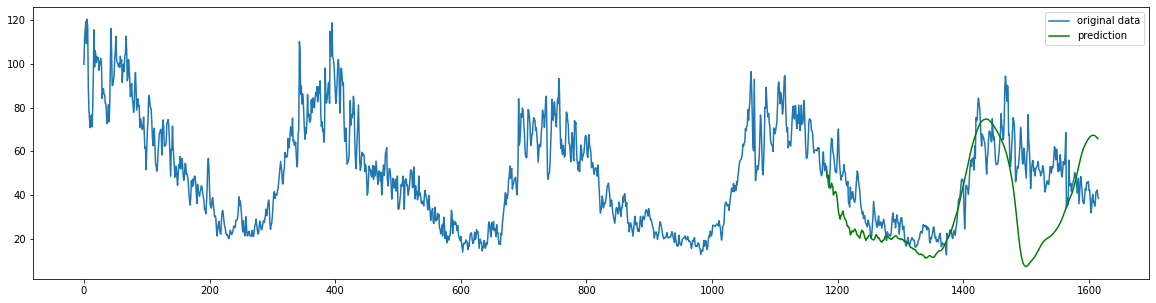

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = auto_reg_pred
# plot baseline and predictions
plt_1 = plt.figure(figsize=(20, 5))
plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
plt.plot(testPredictPlot, color='g')
plt.legend(["original data", "prediction"], loc="upper right")
plt.show()

## gru evaluation scores

In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(inverse_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(inverse_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.52 RMSE
Test Score: 5.44 RMSE


In [ ]:
trainScore = r2_score(inverse_trainY[0], trainPredict[:,0])
print('Train Score: %.5f R2' % (trainScore))
testScore = r2_score(inverse_testY[0], testPredict[:,0])
print('Test Score: %.5f R2' % (testScore))

Train Score: 0.93493 R2
Test Score: 0.90167 R2


# Bi-directional GRU with 1 layer

## bi-gru model creation

In [ ]:
# create and fit the Bi-directional LSTM network
bigru_model = Sequential()
# adding bi-directional layer
bigru_model.add(Bidirectional(LSTM(1, input_shape=(1, look_back))))
bigru_model.add(Dense(1))
bigru_model.compile(loss='mean_squared_error', optimizer='adam')
hist = bigru_model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/30
981/981 - 5s - loss: 0.0149 - 5s/epoch - 5ms/step
Epoch 2/30
981/981 - 2s - loss: 0.0057 - 2s/epoch - 2ms/step
Epoch 3/30
981/981 - 2s - loss: 0.0051 - 2s/epoch - 2ms/step
Epoch 4/30
981/981 - 2s - loss: 0.0047 - 2s/epoch - 2ms/step
Epoch 5/30
981/981 - 2s - loss: 0.0043 - 2s/epoch - 2ms/step
Epoch 6/30
981/981 - 2s - loss: 0.0040 - 2s/epoch - 2ms/step
Epoch 7/30
981/981 - 2s - loss: 0.0038 - 2s/epoch - 2ms/step
Epoch 8/30
981/981 - 2s - loss: 0.0037 - 2s/epoch - 2ms/step
Epoch 9/30
981/981 - 2s - loss: 0.0036 - 2s/epoch - 2ms/step
Epoch 10/30
981/981 - 2s - loss: 0.0034 - 2s/epoch - 2ms/step
Epoch 11/30
981/981 - 2s - loss: 0.0033 - 2s/epoch - 2ms/step
Epoch 12/30
981/981 - 2s - loss: 0.0032 - 2s/epoch - 2ms/step
Epoch 13/30
981/981 - 2s - loss: 0.0032 - 2s/epoch - 2ms/step
Epoch 14/30
981/981 - 2s - loss: 0.0032 - 2s/epoch - 2ms/step
Epoch 15/30
981/981 - 2s - loss: 0.0031 - 2s/epoch - 2ms/step
Epoch 16/30
981/981 - 2s - loss: 0.0030 - 2s/epoch - 2ms/step
Epoch 17/30
981/9

## get predictions

In [ ]:
# make predictions
trainPredict = bigru_model.predict(trainX)
testPredict = bigru_model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
inverse_trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
inverse_testY = scaler.inverse_transform([testY])

### plot bi-gru prediction

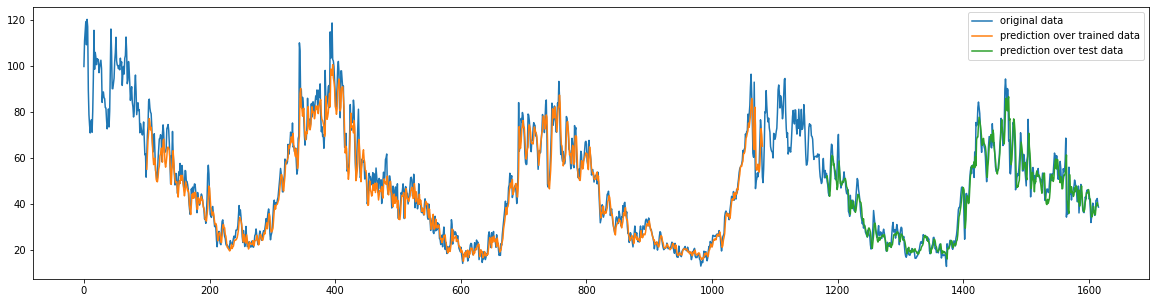

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt_1 = plt.figure(figsize=(20, 5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(["original data","prediction over trained data", "prediction over test data"], loc="upper right")
plt.show()

## auto-regressive gru prediction

In [ ]:
from tqdm import tqdm


auto_reg_test = np.array([testX[0]])
auto_reg_pred = []
for i in tqdm(range(len(test)-look_back-1)):
  pred = bigru_model.predict(auto_reg_test)[0]
  auto_reg_pred.append(pred)
  auto_reg_test = list(auto_reg_test[0][0])[1:]
  auto_reg_test.append(pred[0])
  auto_reg_test = np.array([[auto_reg_test]])


auto_reg_pred = np.array(auto_reg_pred)
auto_reg_pred = scaler.inverse_transform(auto_reg_pred)

100%|██████████| 433/433 [00:21<00:00, 20.25it/s]


### plot auto-regressive bigru prediction

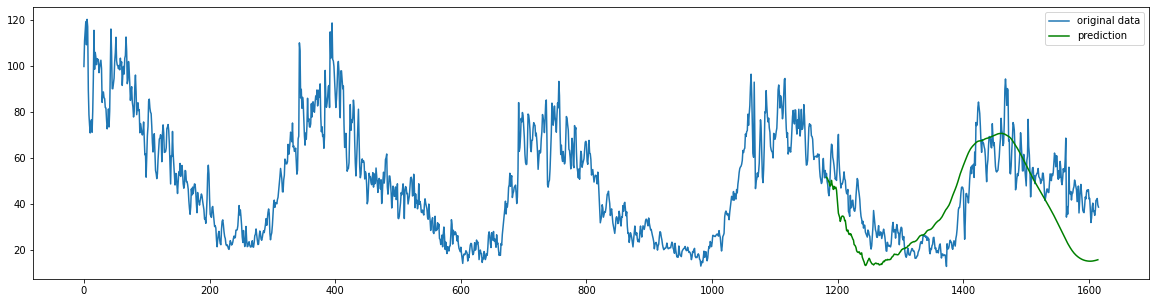

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = auto_reg_pred
# plot baseline and predictions
plt_1 = plt.figure(figsize=(20, 5))
plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
plt.plot(testPredictPlot, color='g')
# plt.axvline( color='r')
plt.legend(["original data", "prediction"], loc="upper right")
plt.show()

## bi-gru evaluation scores

In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(inverse_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(inverse_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.21 RMSE
Test Score: 4.98 RMSE


In [ ]:
trainScore = r2_score(inverse_trainY[0], trainPredict[:,0])
print('Train Score: %.5f R2' % (trainScore))
testScore = r2_score(inverse_testY[0], testPredict[:,0])
print('Test Score: %.5f R2' % (testScore))

Train Score: 0.94210 R2
Test Score: 0.91752 R2


# DeepAR

## install required module

In [ ]:
! pip install mxnet gluonts ujson

## imports

In [ ]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

In [ ]:
print("start:\t{}\nEnd:\t{}\nSplit:\t{}".format(df.index[0], df.index[-1], df.index[1082]))

start:	2017-11-07
End:	2022-06-04
Split:	2020-11-29


## Data preparation

In [ ]:
training_data = ListDataset(
    [{"start": df.index[0], "target": df['PM2.5'][:"2020-11-29"], }],
    freq = "D"
)

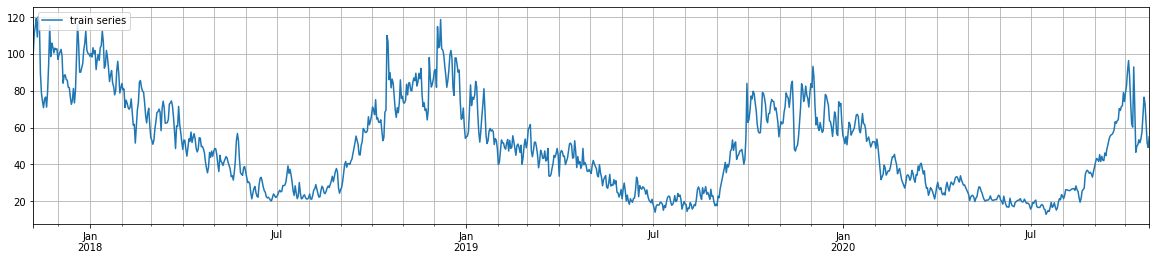

In [ ]:
entry = next(iter(training_data))
train_series = to_pandas(entry)
train_series.plot(figsize=(20,4))
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

In [ ]:
test_data = ListDataset(
    [{"start": df.index[0], "target": df['PM2.5'][:"2022-11-29"]}],
    freq = "D"
)

### plot showing train and test data

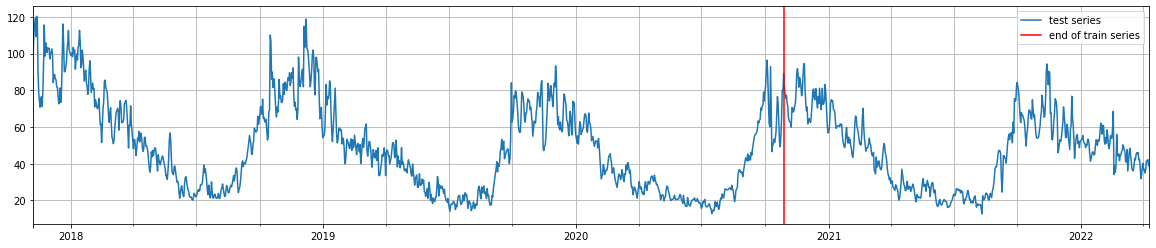

In [ ]:
entry = next(iter(test_data))
test_series = to_pandas(entry)
test_series.plot(figsize=(20,4))
plt.axvline(df.index[1051], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper right")
plt.show()

## Training DeepAR model

In [ ]:
callbacks = [
    LearningRateReduction(objective="min",
                          patience=5,
                          base_lr=1e-3,
                          decay_factor=0.5,
                          ),
    ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]

estimator = DeepAREstimator(
    freq="D",
    prediction_length=433,
    context_length=1082,
    num_layers = 2,
    num_cells = 40,
    distr_output=StudentTOutput(),
    dropout_rate=0.01,
    trainer=Trainer(#ctx = mx.context.gpu(),
                    epochs=10,
                    callbacks=callbacks))

predictor = estimator.train(training_data)

100%|██████████| 50/50 [03:16<00:00,  3.93s/it, epoch=10/10, avg_epoch_loss=2.79]


## Predicting with DeepAR model

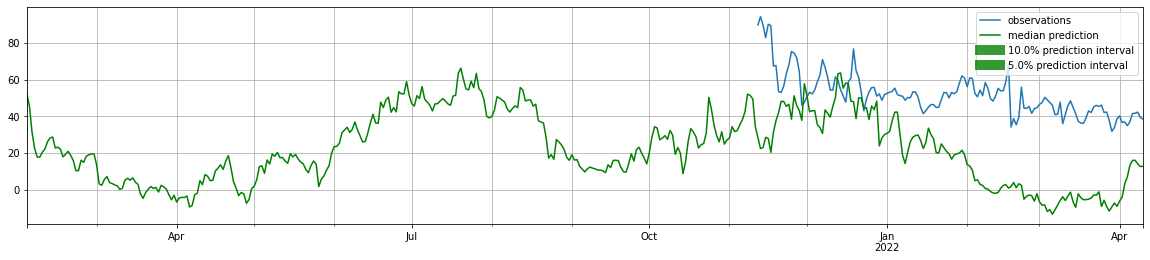

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=1,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (5.0, 10.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 4))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.axvline(df.index[105], color='r')
    plt.legend(legend, loc="upper right")
    plt.show()

plot_prob_forecasts(ts_entry, forecast_entry)

## DeepAR evaluation scores

In [ ]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

import json
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


{
    "MSE": 59.26873779296875,
    "abs_error": 44.66020202636719,
    "abs_target_sum": 240.27374267578125,
    "abs_target_mean": 40.045623779296875,
    "seasonal_error": 3.5669194156890924,
    "MASE": 2.0867774504954855,
    "MAPE": 0.18358057737350464,
    "sMAPE": 0.20394017299016318,
    "MSIS": 5.917904470071748,
    "QuantileLoss[0.1]": 16.693463516235354,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.2]": 27.947412109375,
    "Coverage[0.2]": 0.0,
    "QuantileLoss[0.3]": 35.99717330932617,
    "Coverage[0.3]": 0.0,
    "QuantileLoss[0.4]": 41.52161865234375,
    "Coverage[0.4]": 0.0,
    "QuantileLoss[0.5]": 44.66020393371582,
    "Coverage[0.5]": 0.0,
    "QuantileLoss[0.6]": 44.40787353515625,
    "Coverage[0.6]": 0.0,
    "QuantileLoss[0.7]": 40.36064071655272,
    "Coverage[0.7]": 0.0,
    "QuantileLoss[0.8]": 31.14698181152344,
    "Coverage[0.8]": 0.16666666666666666,
    "QuantileLoss[0.9]": 14.444373321533204,
    "Coverage[0.9]": 0.3333333333333333,
    "RMSE": 7.